In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/abie/projects/2023/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [3]:
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                               'age_start': 40,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-10-31 16:20:44.465 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-10-31 16:20:44.467 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-10-31 16:20:44.470 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,alive,entrance_time,sex,age,exit_time,location,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_therapeutic_inertia_constant_component,sbp_multiplier,ldlc_multiplier,outreach,sbp_medication,ldlc_medication,polypill,last_fpg_test_date,visit_type,scheduled_date
0,True,alive,2020-12-04,Female,62.325405,NaT,Alabama,not_dead,0.0,,...,0.095895,1.00,1.3620,cat2,no_treatment,medium_intensity,cat2,NaT,none,NaT
1,True,alive,2020-12-04,Male,56.583394,NaT,Alabama,not_dead,0.0,,...,0.528809,1.00,1.5125,cat2,no_treatment,high_intensity,cat2,NaT,none,2021-03-21 23:06:47.554560
2,True,alive,2020-12-04,Female,63.072592,NaT,Alabama,not_dead,0.0,,...,0.558211,1.00,1.0000,cat2,no_treatment,no_treatment,cat2,NaT,none,NaT
3,True,alive,2020-12-04,Male,50.472918,NaT,Alabama,not_dead,0.0,,...,-0.027969,1.12,1.0000,cat2,two_drug_half_dose_efficacy,low_intensity,cat2,NaT,none,NaT
4,True,alive,2020-12-04,Female,49.552787,NaT,Alabama,not_dead,0.0,,...,-0.353543,1.00,1.3620,cat2,one_drug_half_dose_efficacy,medium_intensity,cat2,NaT,none,NaT


In [5]:
pop0.columns

Index(['tracked', 'alive', 'entrance_time', 'sex', 'age', 'exit_time',
       'location', 'cause_of_death', 'years_of_life_lost',
       'previous_ischemic_stroke',
       'previous_ischemic_heart_disease_and_heart_failure',
       'high_body_mass_index_in_adults_propensity',
       'high_systolic_blood_pressure_propensity',
       'high_fasting_plasma_glucose_propensity',
       'high_ldl_cholesterol_propensity', 'ischemic_stroke',
       'ischemic_heart_disease_and_heart_failure',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity',
       'susceptible_to_ischemic_stroke_event_time',
       'susce

In [6]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'acute_ischemic_stroke.incidence_rate',
 'acute_ischemic_stroke.incidence_rate.paf',
 'acute_ischemic_stroke.dwell_time',
 'acute_ischemic_stroke.disability_weight',
 'disability_weight',
 'acute_ischemic_stroke.excess_mortality_rate',
 'acute_ischemic_stroke.excess_mortality_rate.paf',
 'mortality_rate',
 'chronic_ischemic_stroke.dwell_time',
 'chronic_ischemic_stroke.disability_weight',
 'chronic_ischemic_stroke.excess_mortality_rate',
 'chronic_ischemic_stroke.excess_mortality_rate.paf',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate.paf',
 'acute_myocardial_infarction.incidence_rate',
 'heart_failure_from_ischemic_heart_disease.incidence_rate',
 'heart_failure_residual.incidence_rate',
 'acute_myocardial_infarction.incidence_rate.paf',
 'heart_failure_from_ischemic_heart_disease.incidence_rate.paf',
 'heart_failure_residual.incidence_rate.paf',
 's

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                  ], axis=1)
data1.head()

,tracked,alive,entrance_time,sex,age,exit_time,location,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_multiplier,outreach,sbp_medication,ldlc_medication,polypill,last_fpg_test_date,visit_type,scheduled_date,high_sbp,high_sbp_raw
0,True,alive,2020-12-04,Female,62.325405,NaT,Alabama,not_dead,0.0,,...,1.3620,cat2,no_treatment,medium_intensity,cat2,NaT,none,NaT,147.192049,147.192049
1,True,alive,2020-12-04,Male,56.583394,NaT,Alabama,not_dead,0.0,,...,1.5125,cat2,no_treatment,high_intensity,cat2,NaT,none,2021-03-21 23:06:47.554560,145.689753,145.689753
2,True,alive,2020-12-04,Female,63.072592,NaT,Alabama,not_dead,0.0,,...,1.0000,cat2,no_treatment,no_treatment,cat2,NaT,none,NaT,94.942811,94.942811
3,True,alive,2020-12-04,Male,50.472918,NaT,Alabama,not_dead,0.0,,...,1.0000,cat2,two_drug_half_dose_efficacy,low_intensity,cat2,NaT,none,NaT,148.753688,165.153688
4,True,alive,2020-12-04,Female,49.552787,NaT,Alabama,not_dead,0.0,,...,1.3620,cat2,one_drug_half_dose_efficacy,medium_intensity,cat2,NaT,none,NaT,139.227528,139.227528


In [8]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
#data1.loc[data1.sbp_medication != 'no_treatment']

## Running time forward 

In [9]:
discontinue_risk = .3/12  # probability of discontinuing treatment during a single time step
# to be applied for the first year of treatment

In [10]:
## This is the function that reset people on meds back to no treatment. 
## I would expect that this is where you will make edits 

global_medication_start = None

def reset_sbp_medication(pop_t, current_timestep):
    ##Call the component with treatment 
    treatment = sim.get_component('treatment')
    ##Get a population view 
    data = treatment.population_view.get(pop_t.index)
    
    global global_medication_start
    if global_medication_start is None: # initialize medication start data
        global_medication_start = pd.Series(-1_000, index=pop_t.index) # this negative value means "not on treatment"
        
        # for individual initially on treatment, pick a random time for them to have been on
        rows_to_initialize_differently = (data['sbp_medication'] != 'no_treatment')
        global_medication_start[rows_to_initialize_differently] = -np.random.choice(range(36),
                                                                                   size=sum(rows_to_initialize_differently))
        
        # for individuals *not* initially on treatment, pick a random set of them to have already stopped treatment
        # TODO: this should be age dependent
        rows_to_initialize_differently = (data['sbp_medication'] == 'no_treatment')
        global_medication_start[rows_to_initialize_differently] = -np.random.choice([999, 1_000],
                                                                                   size=sum(rows_to_initialize_differently),
                                                                                   p=[.3,.7])
        
    # undo treatment for any -999 rows
    no_med_rows = (global_medication_start == -999)
    data.loc[no_med_rows, 'sbp_medication'] = 'no_treatment'

    # record timestep that this changed
    new_med_rows = (data['sbp_medication'] != 'no_treatment') & (global_medication_start == -1_000)
    global_medication_start[new_med_rows] = current_timestep
    
    
    ##Actual edit the data 
    ##More specifically this is where we will make edits to have the first year reset 
    rows_to_consider = ((data['sbp_medication'] != 'no_treatment')
                        & (global_medication_start >= current_timestep - 12))
    
    indices_to_change = rows_to_consider & (np.random.uniform(size=len(rows_to_consider)) <= discontinue_risk)
    data.loc[indices_to_change, 'sbp_medication'] = 'no_treatment'
    global_medication_start[indices_to_change] = -999  # this negative value means "was on treatment, but not anymore"
    
    ##Update the data in the population view with the new dataframe that was edited 
    treatment.population_view.update(data)
    return 

In [11]:
%%time

## I would reset this to 1 time step or 5 time steps to test it 

sim_data = pd.DataFrame()
for step in list(range(0,12*22)):
    sim.step()
    pop_t = sim.get_population()
    reset_sbp_medication(pop_t, step) 
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                       ],axis=1)
    data_t['step'] = step
    data_t_small = data_t[['sex','age','alive','high_sbp','high_sbp_raw','sbp_medication','step']]
    print(step)
    sim_data = pd.concat([sim_data, data_t_small])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


ValueError: Invalid values '{'2041'}' found in current_year.

In [12]:
## Save the data - I find this helpful so that if things happen overnight (internet outage, jupyter crash) I still have a copy 

sim_data.to_csv('data/med_data_250steps_10_27_23.csv')

# Read in Data and Analysis 

In [13]:
data = pd.read_csv('data/med_data_250steps_10_27_23.csv')

In [14]:
data1 = data.loc[(data.age > 25) & (data.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1['need_meds'] = np.where(data1.high_sbp_raw > 130, 1, 0)

In [15]:
data_need_med = data1.loc[data1.need_meds == 1]
data_need_med.head()

,Unnamed: 0,sex,age,alive,high_sbp,high_sbp_raw,sbp_medication,step,age_start,need_meds
0,0,Female,62.402065,alive,147.192049,147.192049,no_treatment,0,60.0,1
1,1,Male,56.660054,alive,145.689753,145.689753,no_treatment,0,55.0,1
3,3,Male,50.549578,alive,148.753688,165.153688,two_drug_half_dose_efficacy,0,50.0,1
4,4,Female,49.629446,alive,139.227528,139.227528,one_drug_half_dose_efficacy,0,45.0,1
5,5,Male,43.606462,alive,135.545603,135.545603,no_treatment,0,40.0,1


In [16]:
grouped = data_need_med.groupby(['sex','age_start','step','sbp_medication']).size()
errors = pd.DataFrame(grouped).reset_index()
errors['error'] = np.sqrt(errors[0])
#errors
percentages = grouped / data_need_med.groupby(['sex','age_start','step']).size() * 100
percentages= pd.DataFrame(percentages)
percentages = percentages.reset_index()
percentages = percentages.merge(errors[['sex','age_start','step','sbp_medication','error']], on = ['sex','age_start','step','sbp_medication'])
percentages['final_error'] = percentages[0].std() / percentages['error']
percentages

,sex,age_start,step,sbp_medication,0,error,final_error
0,Female,40.0,0,no_treatment,57.419355,9.433981,1.855988
1,Female,40.0,0,one_drug_half_dose_efficacy,25.806452,6.324555,2.768472
2,Female,40.0,0,one_drug_std_dose_efficacy,0.645161,1.000000,17.509355
3,Female,40.0,0,two_drug_half_dose_efficacy,16.129032,5.000000,3.501871
4,Female,40.0,1,no_treatment,53.246753,9.055385,1.933585
...,...,...,...,...,...,...,...
37076,Male,120.0,12,no_treatment,100.000000,1.000000,17.509355
37077,Male,120.0,13,no_treatment,100.000000,1.000000,17.509355
37078,Male,120.0,14,no_treatment,100.000000,1.000000,17.509355
37079,Male,120.0,15,no_treatment,100.000000,1.000000,17.509355


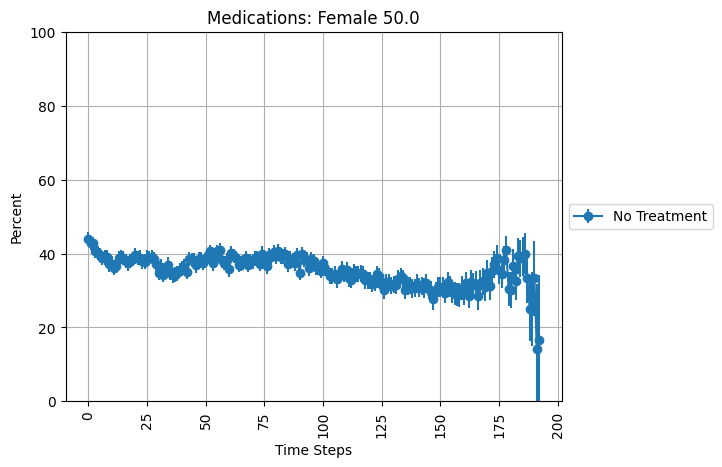

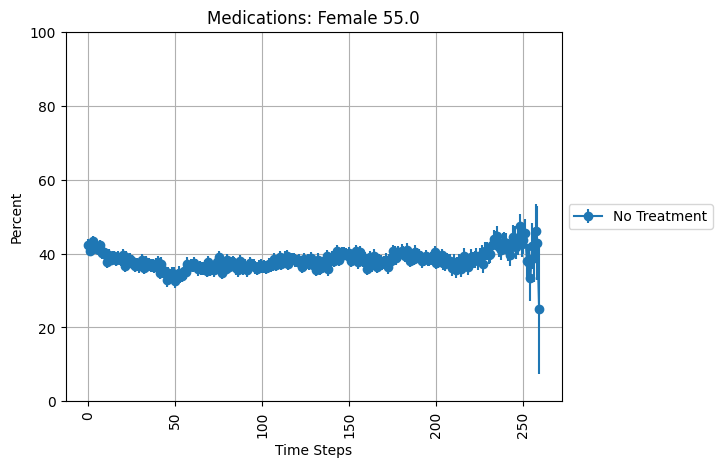

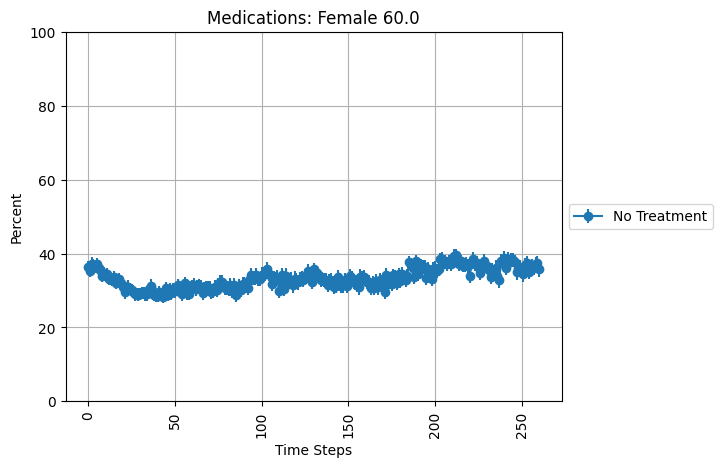

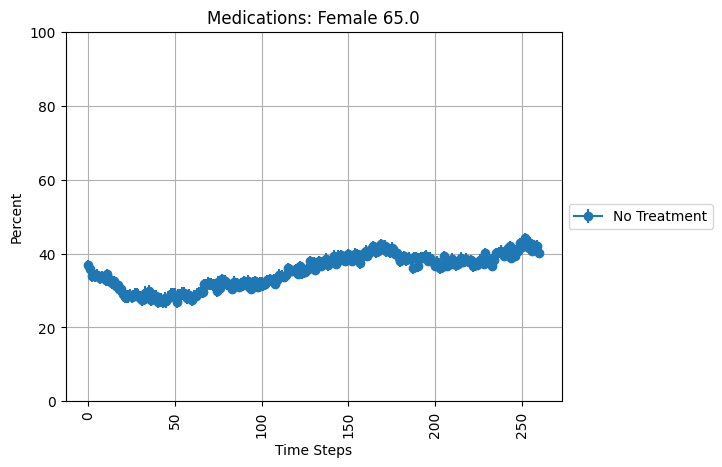

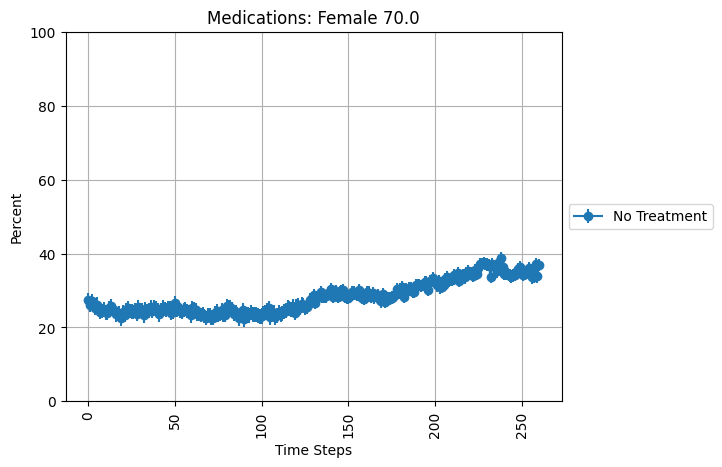

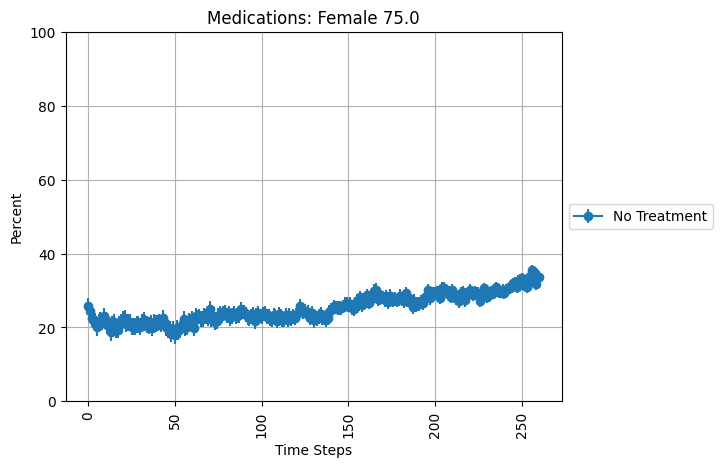

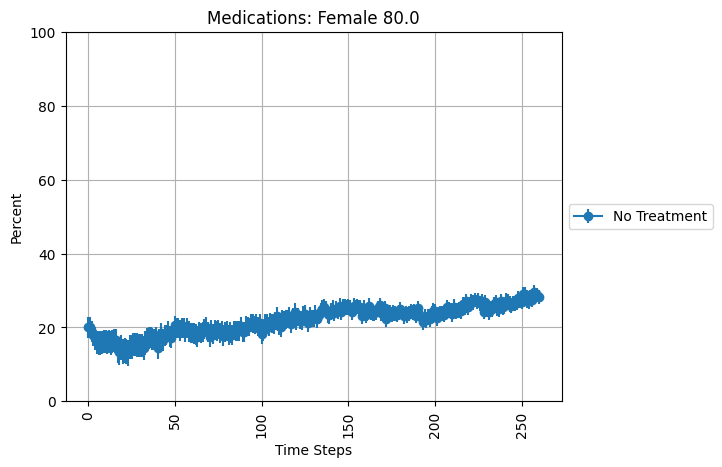

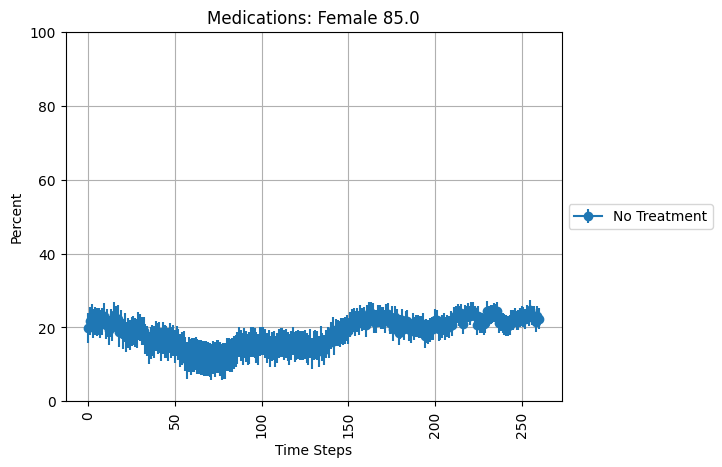

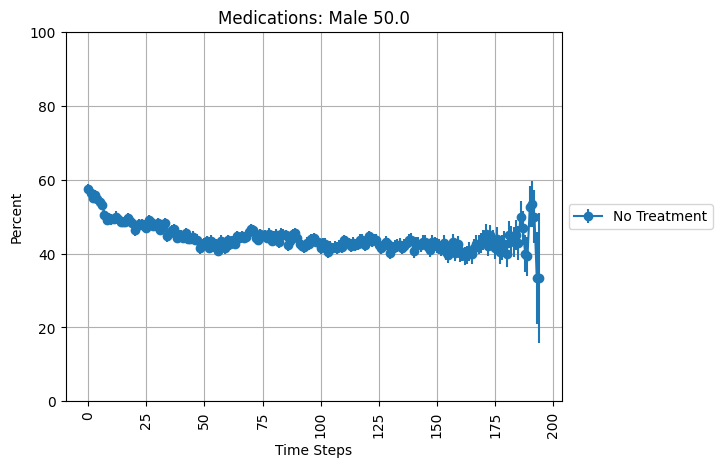

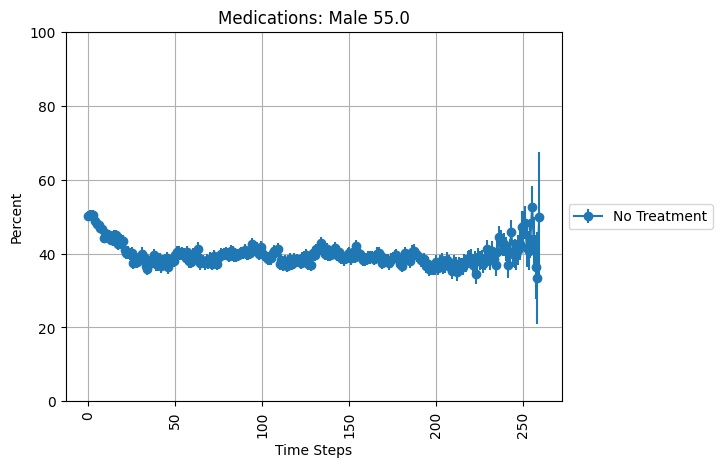

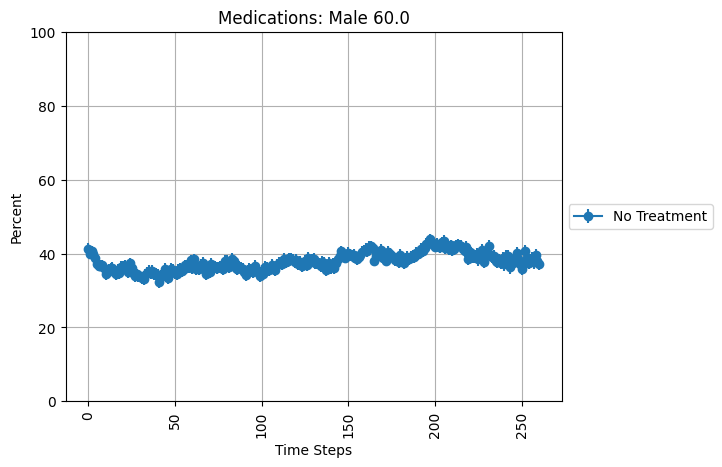

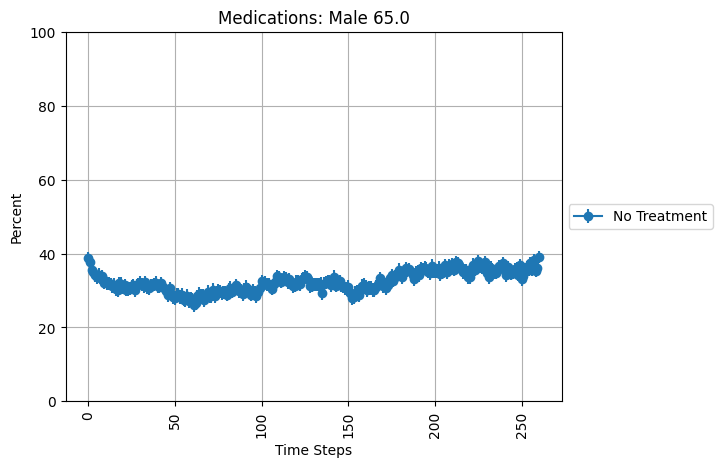

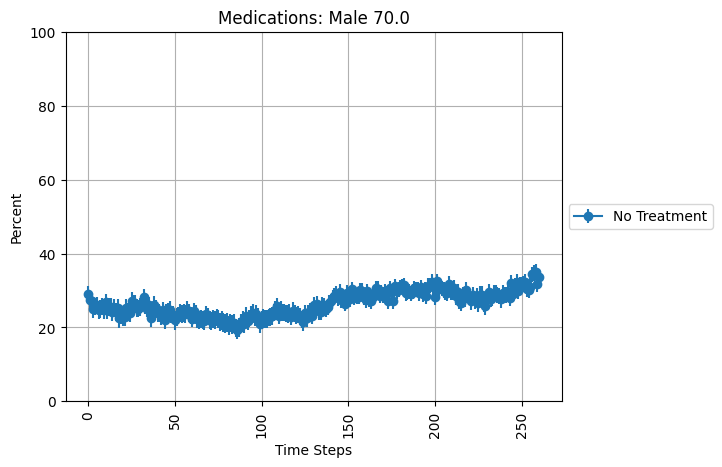

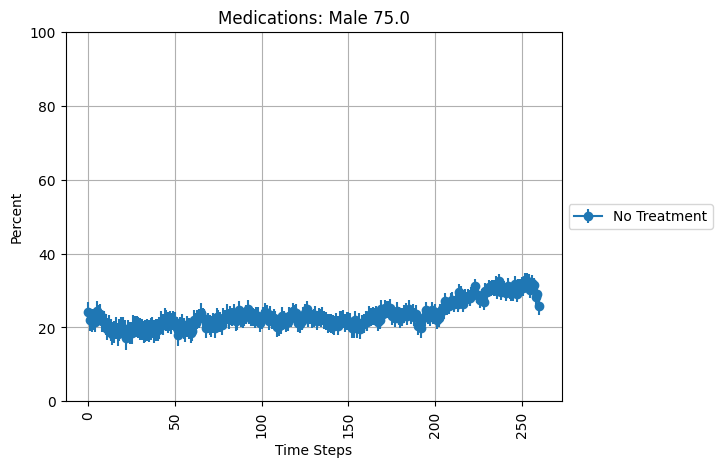

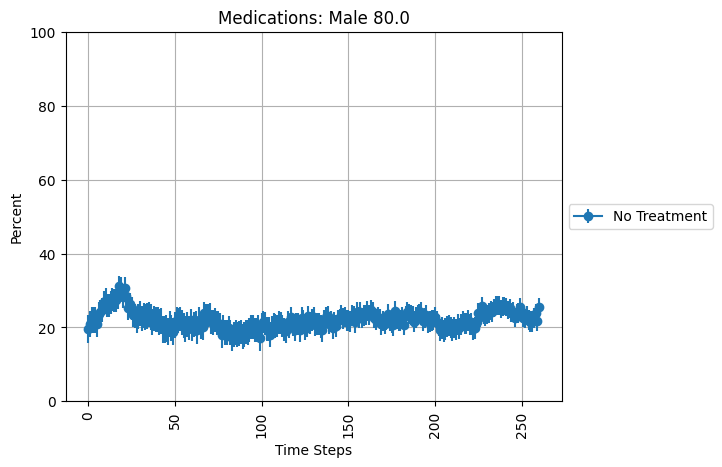

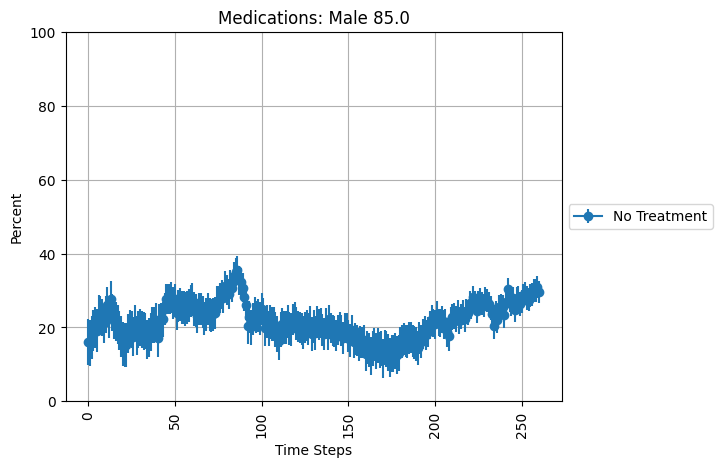

In [18]:
for sex in percentages.sex.unique():
    for age in percentages.age_start.unique():
        if age < 50 or age > 85:
            continue
            
        plt.figure() 
        no_trt = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='no_treatment')]
        plt.errorbar(no_trt['step'], no_trt[0], yerr=no_trt['final_error'], marker='o')
        #one_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_half_dose_efficacy')]
        #plt.plot(one_half['step'], one_half[0], marker='o')
        #one_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_std_dose_efficacy')]
        #plt.plot(one_std['step'], one_std[0], marker='o')
        #two_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_half_dose_efficacy')]
        #plt.plot(two_half['step'], two_half[0], marker='o')
        #two_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_std_dose_efficacy')]
        #plt.plot(two_std['step'], two_std[0], marker='o')
        #three_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_half_dose_efficacy')]
        #plt.plot(three_half['step'], three_half[0], marker='o')
        #three_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_std_dose_efficacy')]
        #plt.plot(three_std['step'], three_std[0], marker='o')
        plt.title(f'Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.ylabel('Percent')
        plt.xlabel('Time Steps')
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()
        plt.axis(ymin=0, ymax=100)